# Tarea 2

In [328]:
# Import necessary libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

# For visualization
import seaborn as sns


## Load and Preprocess Images:

In [329]:
# Load the images 
img_fragments = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
img_pellets = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
img_tar = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Convert images to grayscale
gray_fragments = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
gray_pellets = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
gray_tar = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)


In [330]:
# Gaussian Blur to reduce noise and improve thresholding
blur_fragments = cv2.GaussianBlur(gray_fragments, (3, 3), sigmaX=0)
blur_pellets = cv2.GaussianBlur(gray_pellets, (3, 3), sigmaX=0)
blur_tar = cv2.GaussianBlur(gray_tar, (3, 3), sigmaX=0)

### Thresholding and Inversion:

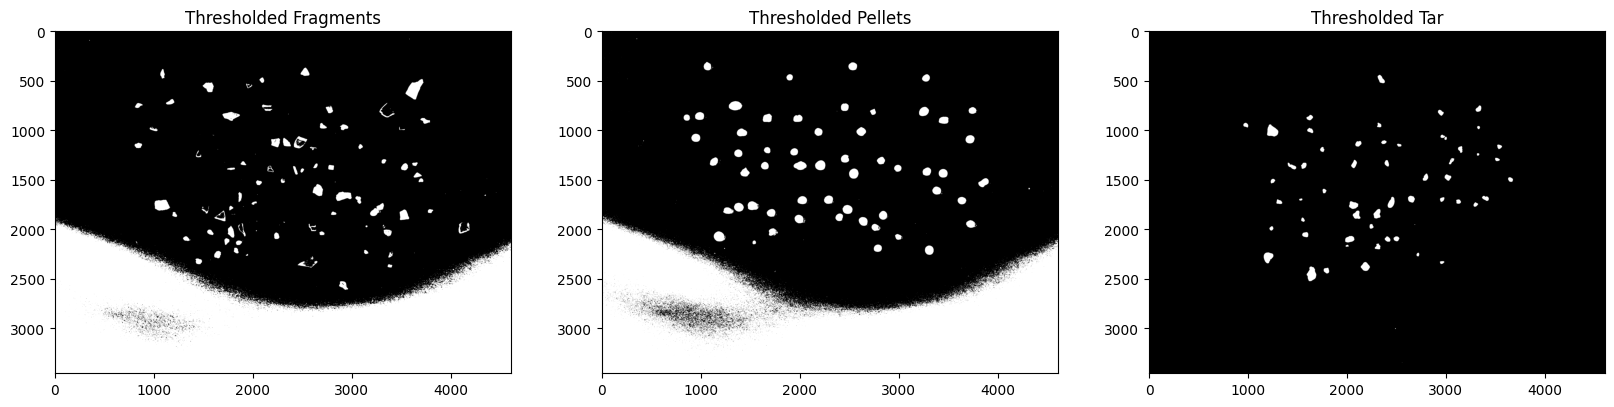

In [331]:
# Apply Otsu's thresholding
_, thresh_fragments = cv2.threshold(blur_fragments, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_pellets = cv2.threshold(blur_pellets, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_tar = cv2.threshold(blur_tar, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert images (particles should be white)
thresh_fragments = cv2.bitwise_not(thresh_fragments)
thresh_pellets = cv2.bitwise_not(thresh_pellets)
thresh_tar = cv2.bitwise_not(thresh_tar)

# Print the thresholded and inverted images
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(thresh_fragments, cmap='gray')
plt.title('Thresholded Fragments')
plt.subplot(132)
plt.imshow(thresh_pellets, cmap='gray')
plt.title('Thresholded Pellets')
plt.subplot(133)
plt.imshow(thresh_tar, cmap='gray')
plt.title('Thresholded Tar')
plt.show()

### Morphological Opening:

In [332]:
# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply opening to remove small objects and noise
opening_fragments = cv2.morphologyEx(thresh_fragments, cv2.MORPH_OPEN, kernel, iterations=2)
opening_pellets = cv2.morphologyEx(thresh_pellets, cv2.MORPH_OPEN, kernel, iterations=2)
opening_tar = cv2.morphologyEx(thresh_tar, cv2.MORPH_OPEN, kernel, iterations=2)

### Contour Detection:

In [333]:
# Find contours for each image
contours_fragments, _ = cv2.findContours(opening_fragments, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_pellets, _ = cv2.findContours(opening_pellets, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_tar, _ = cv2.findContours(opening_tar, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [334]:
# Set a minimum area threshold to filter out noise
min_area = 600

# Filter contours based on area
filtered_fragments = [cnt for cnt in contours_fragments if cv2.contourArea(cnt) > min_area]
filtered_pellets = [cnt for cnt in contours_pellets if cv2.contourArea(cnt) > min_area]
filtered_tar = [cnt for cnt in contours_tar if cv2.contourArea(cnt) > min_area]

## Feature Extraction

In [335]:
def extract_features(contour):
    features = {}
    # Area
    area = cv2.contourArea(contour)
    features['area'] = area

    # Perimeter
    perimeter = cv2.arcLength(contour, True)
    features['perimeter'] = perimeter

    # Compactness
    if area != 0:
        compactness = (perimeter ** 2) / area
    else:
        compactness = 0
    features['compactness'] = compactness

    # Bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    features['aspect_ratio'] = aspect_ratio

    # Extent (area ratio)
    rect_area = w * h
    extent = area / rect_area if rect_area != 0 else 0
    features['extent'] = extent

    # Ellipse axes ratio
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (center, axes, orientation) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)
        ellipse_axis_ratio = minor_axis / major_axis if major_axis != 0 else 0
        features['ellipse_axis_ratio'] = ellipse_axis_ratio
    else:
        features['ellipse_axis_ratio'] = 0

    return features

In [336]:
# Initialize a list to store data
data = []

# Process fragments
for contour in filtered_fragments:
    features = extract_features(contour)
    features['label'] = 'Fragment'
    data.append(features)

# Process pellets
for contour in filtered_pellets:
    features = extract_features(contour)
    features['label'] = 'Pellet'
    data.append(features)

# Process tar
for contour in filtered_tar:
    features = extract_features(contour)
    features['label'] = 'Tar'
    data.append(features)

# Create a DataFrame
df = pd.DataFrame(data)


     area   perimeter  compactness  aspect_ratio    extent  \
0  4599.0  321.480228    22.472176      1.034884  0.600862   
1  1107.5  136.183765    16.745840      1.437500  0.752378   
2  2034.5  257.923880    32.698318      1.600000  0.508625   
3  2837.0  214.024385    16.146083      1.157895  0.754120   
4  1281.0  187.882249    27.556393      0.884615  0.535535   

   ellipse_axis_ratio     label  
0            0.635303  Fragment  
1            0.674071  Fragment  
2            0.661490  Fragment  
3            0.823970  Fragment  
4            0.699994  Fragment  
               area     perimeter  compactness  aspect_ratio      extent  \
count  1.790000e+02    179.000000   179.000000    179.000000  179.000000   
mean   5.216578e+04    524.252841    22.267550      1.152779    0.674959   
std    4.573166e+05   2602.969271    20.681363      0.457458    0.115874   
min    6.155000e+02     98.669047    14.198277      0.353535    0.132320   
25%    1.595750e+03    179.731491    15.170

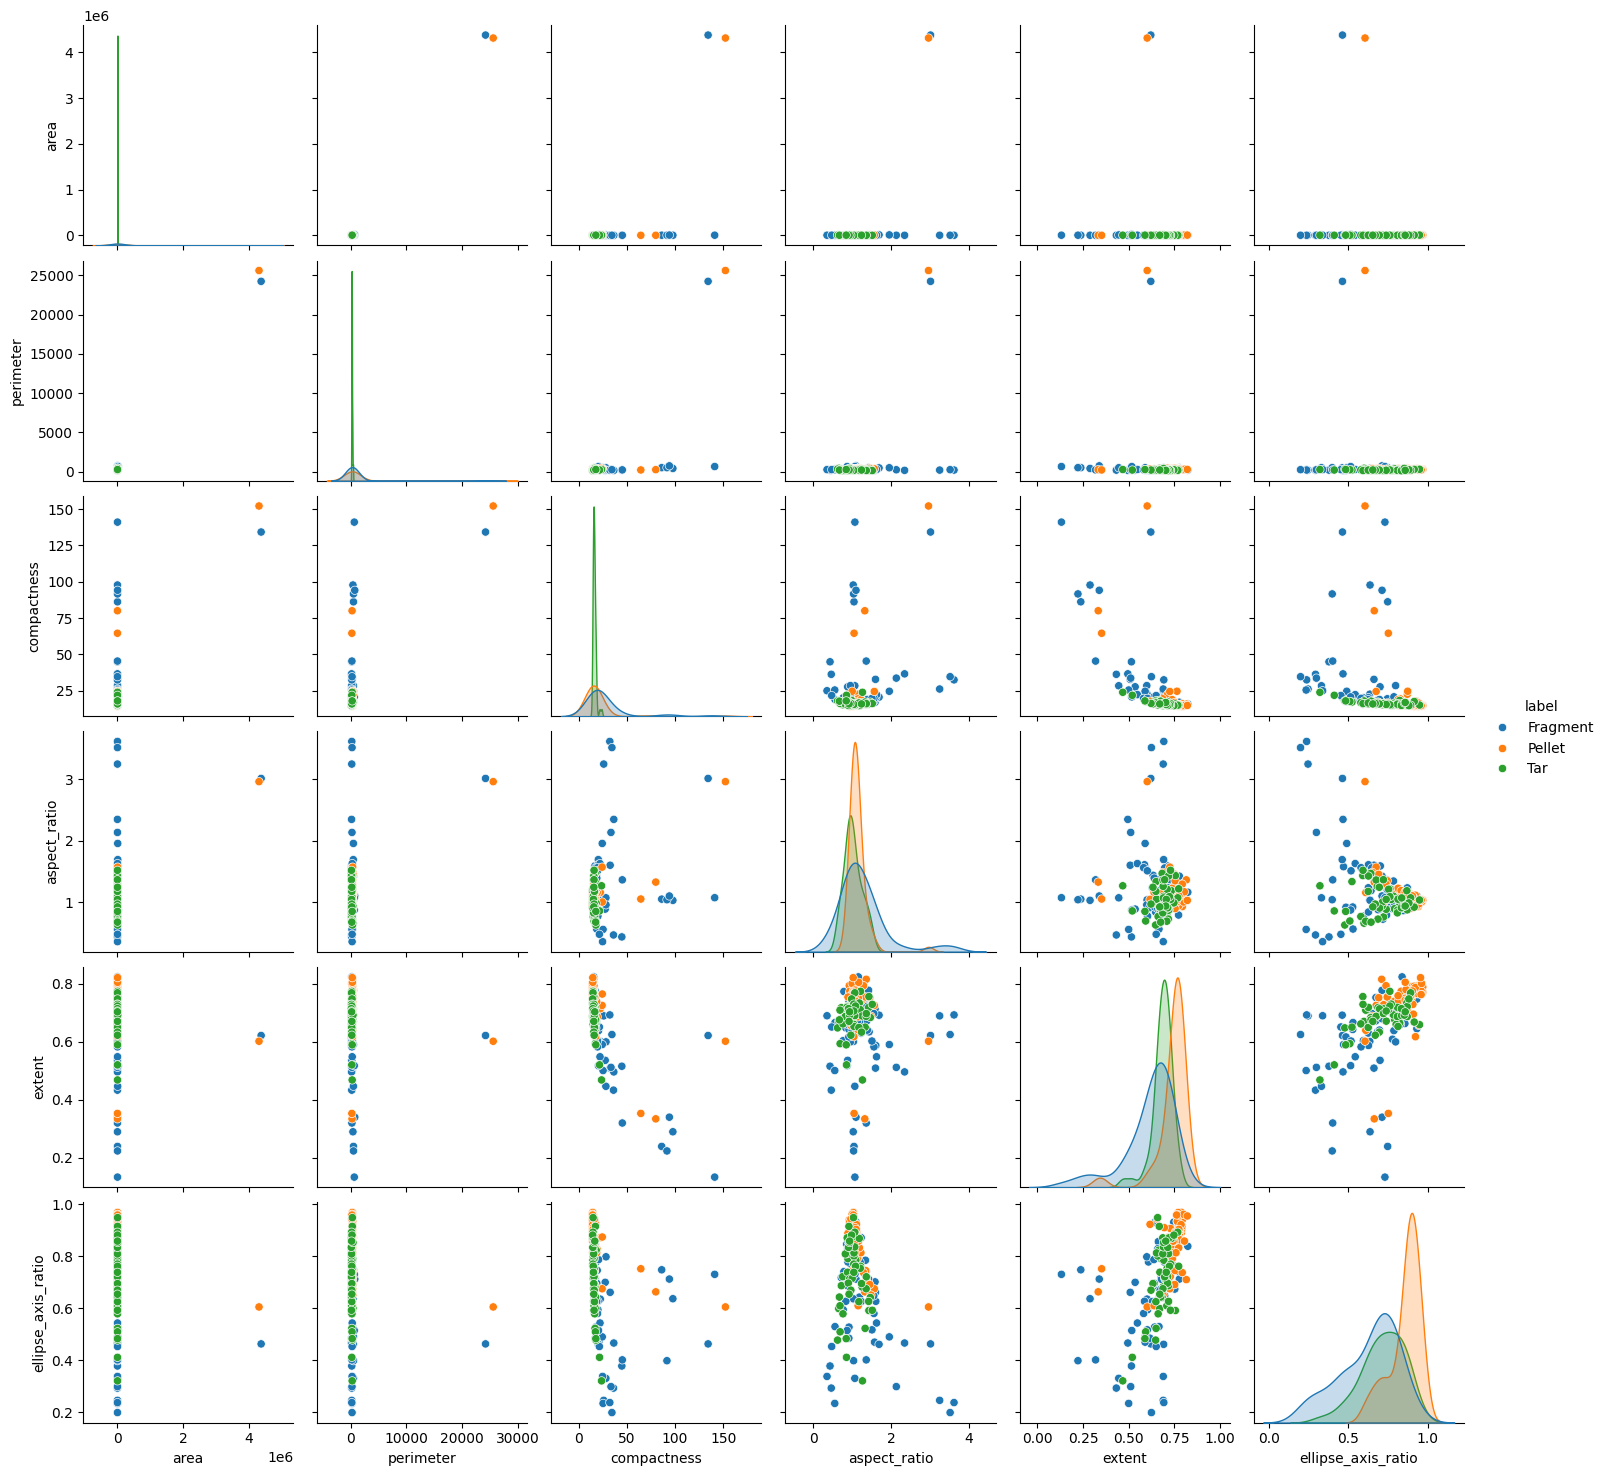

In [337]:
# Display first few rows
print(df.head())

# Statistical summary
print(df.describe())

# Visualize feature distribution
sns.pairplot(df, hue='label')
plt.show()

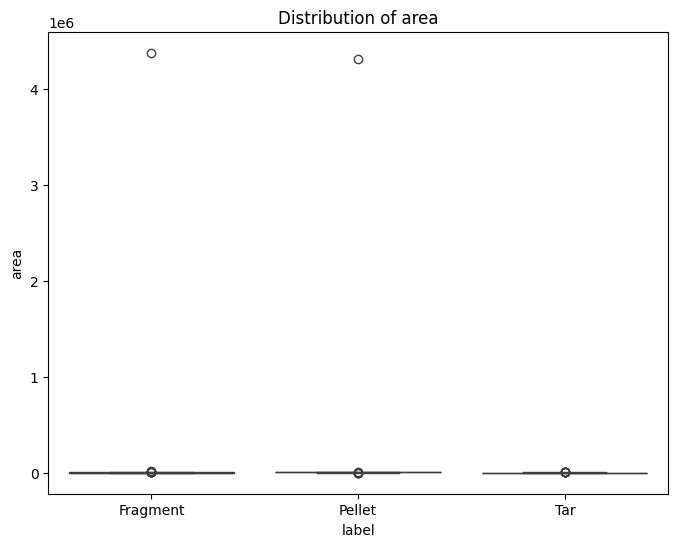

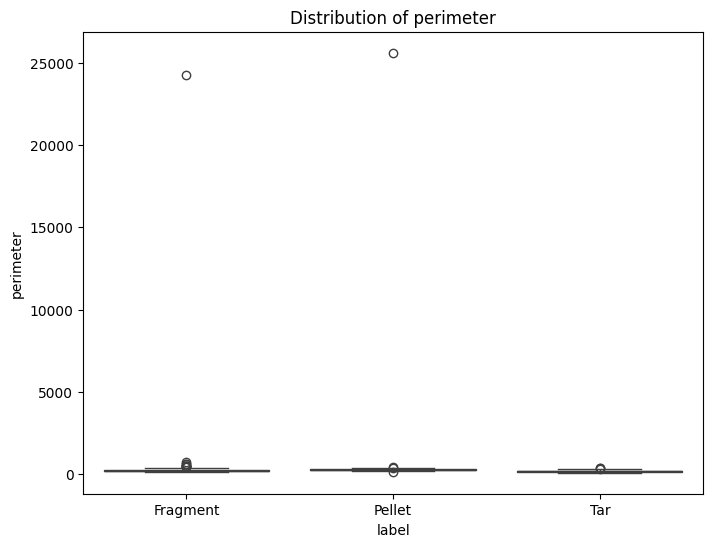

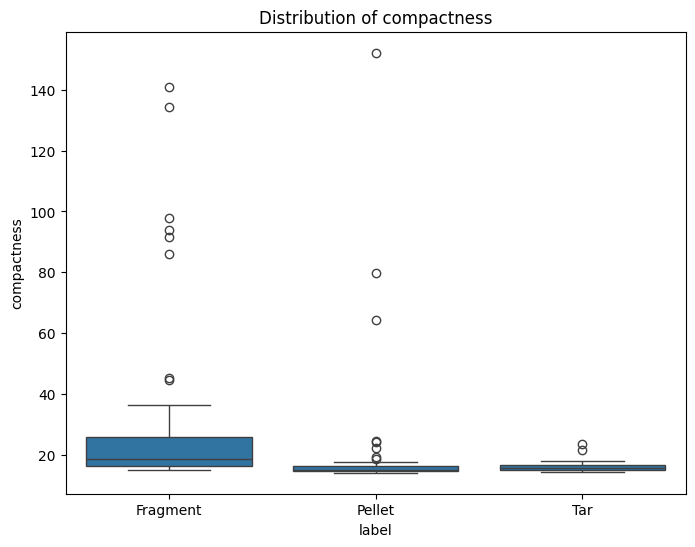

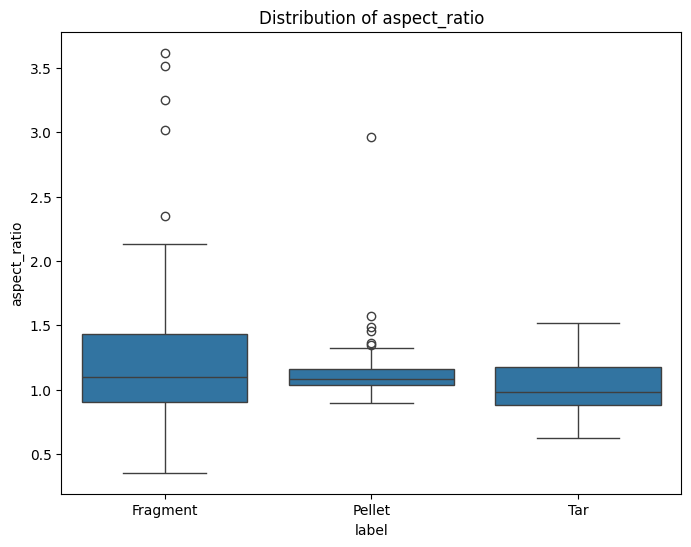

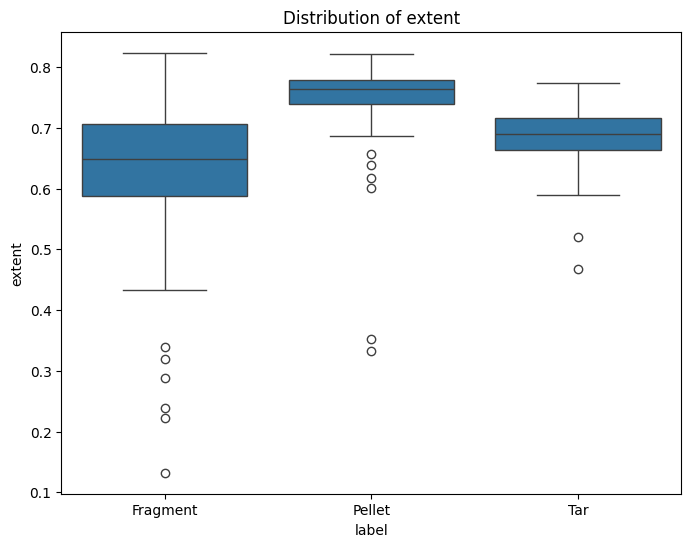

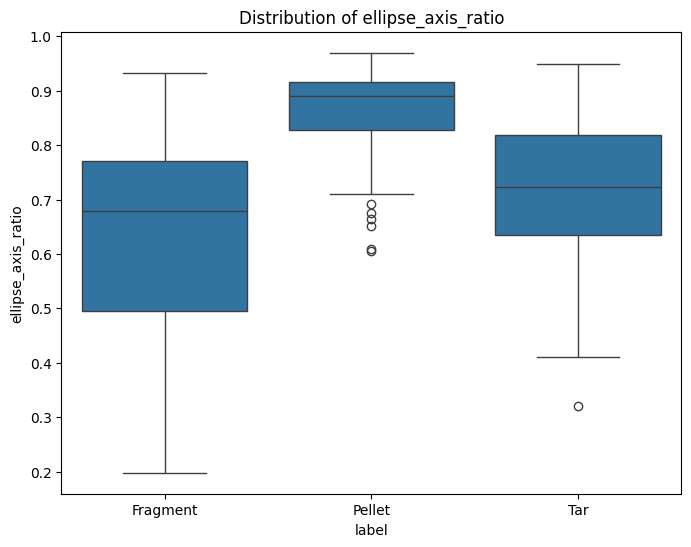

In [338]:
# Boxplots for each feature
features = ['area', 'perimeter', 'compactness', 'aspect_ratio', 'extent', 'ellipse_axis_ratio']

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [339]:
# Calculate mean and std per class
grouped = df.groupby('label').agg(['mean', 'std'])
print(grouped)

                  area                  perimeter              compactness  \
                  mean            std        mean          std        mean   
label                                                                        
Fragment  65672.821429  522458.003010  599.624566  2867.822607   28.479550   
Pellet    79418.232759  565236.727812  721.364007  3325.027385   20.079161   
Tar        2633.715686    1982.423555  196.635814    69.248512   16.230029   

                    aspect_ratio              extent            \
                std         mean       std      mean       std   
label                                                            
Fragment  26.068392     1.265597  0.641675  0.615582  0.137873   
Pellet    20.634028     1.136317  0.279531  0.739297  0.087518   
Tar        1.659566     1.016651  0.225102  0.683288  0.055021   

         ellipse_axis_ratio            
                       mean       std  
label                                  
Fragment      

In [340]:
def classifier(features):
    # Extract feature values
    compactness = features['compactness']
    aspect_ratio = features['aspect_ratio']
    ellipse_axis_ratio = features['ellipse_axis_ratio']
    extent = features['extent']
    
    # Adjusted thresholds based on data
    compactness_fragment_threshold = 21.7  # Mean between Tar and Fragment
    compactness_pellet_threshold = 15.47   # Mean between Pellet and Tar
    ellipse_axis_ratio_pellet_threshold = 0.787  # Mean between Pellet and Tar
    extent_pellet_threshold = 0.714        # Mean between Pellet and Tar
    aspect_ratio_fragment_threshold = 1.27 # Mean between Tar and Fragment
    
    # Classification rules based on adjusted thresholds
    if compactness > compactness_fragment_threshold:
        return 'Fragment'
    elif compactness < compactness_pellet_threshold:
        if ellipse_axis_ratio > ellipse_axis_ratio_pellet_threshold and extent > extent_pellet_threshold:
            return 'Pellet'
        else:
            return 'Tar'
    else:
        if aspect_ratio > aspect_ratio_fragment_threshold:
            return 'Fragment'
        else:
            return 'Tar'


In [341]:
# Apply the classifier to each particle
df['predicted_label'] = df.apply(classifier, axis=1)


In [342]:
from sklearn.metrics import confusion_matrix, classification_report

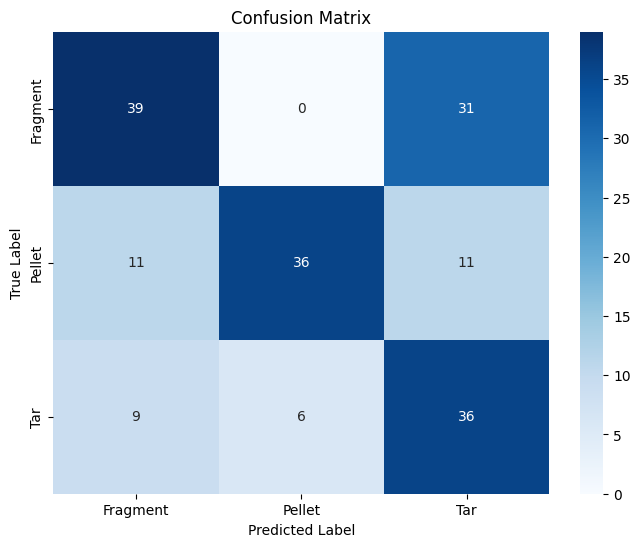

              precision    recall  f1-score   support

    Fragment       0.66      0.56      0.60        70
      Pellet       0.86      0.62      0.72        58
         Tar       0.46      0.71      0.56        51

    accuracy                           0.62       179
   macro avg       0.66      0.63      0.63       179
weighted avg       0.67      0.62      0.63       179



In [343]:
# Actual labels
y_true = df['label']
# Predicted labels
y_pred = df['predicted_label']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Fragment', 'Pellet', 'Tar'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Fragment', 'Pellet', 'Tar'], yticklabels=['Fragment', 'Pellet', 'Tar'], cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [344]:
# Function to classify and visualize particles in an image
def classify_and_visualize_manual(original_img, contours):
    img_output = original_img.copy()
    for contour in contours:
        # Extract features
        features = extract_features(contour)
    
        # Predict the label using manual classifier
        predicted_label = classifier(features)
    
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
    
        # Draw rectangle and label
        cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_output, predicted_label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Convert BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Classification Results')
    plt.show()


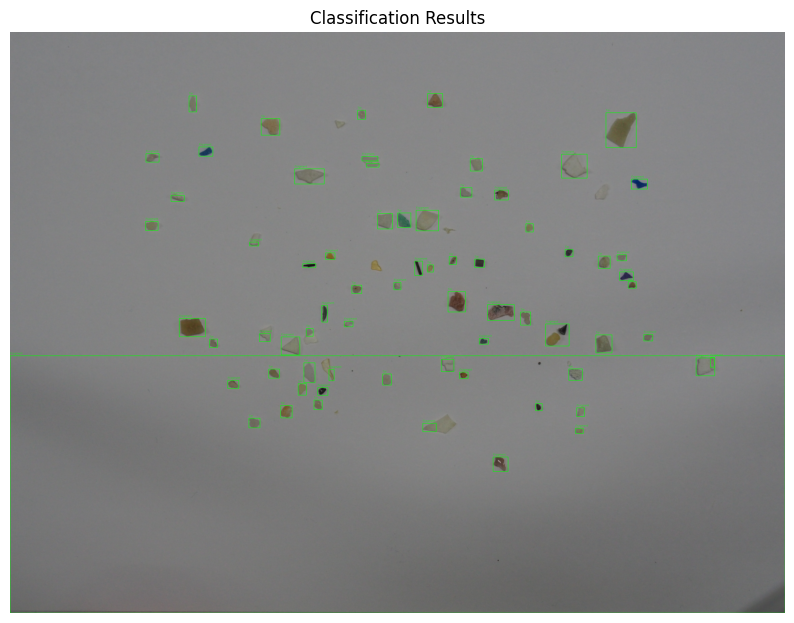

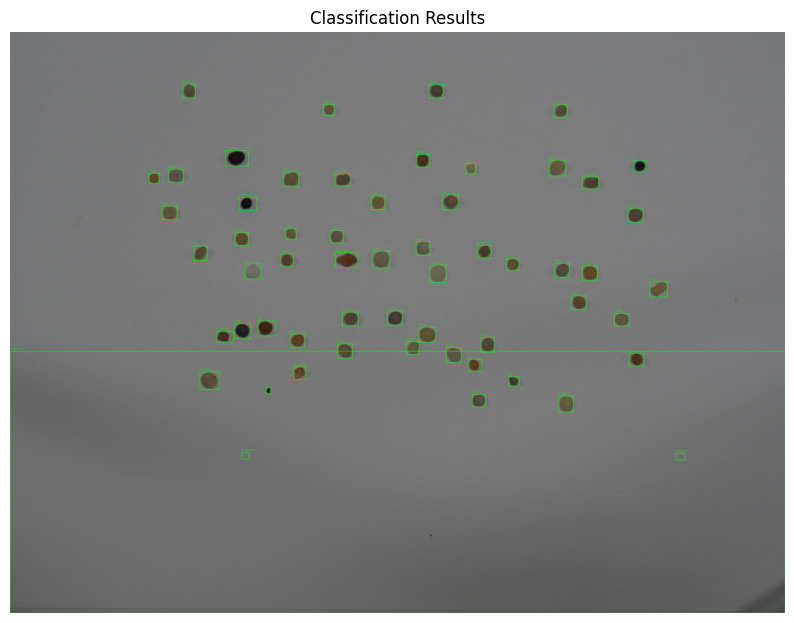

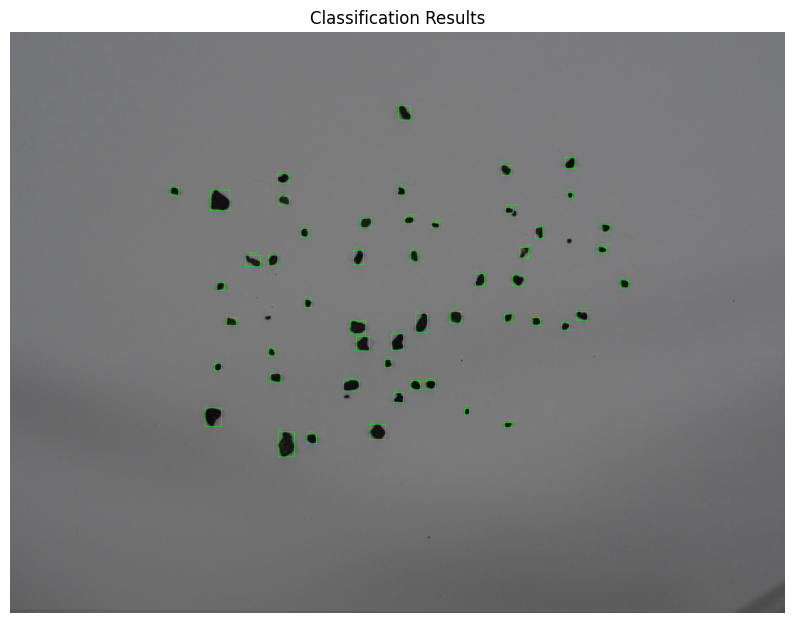

In [345]:
# Visualize results on the fragments image
classify_and_visualize_manual(img_fragments, filtered_fragments)

# Visualize results on the pellets image
classify_and_visualize_manual(img_pellets, filtered_pellets)

# Visualize results on the tar image
classify_and_visualize_manual(img_tar, filtered_tar)
